In [7]:
import sys
sys.path.insert(0, '../')
import numpy as np
import torch
import matplotlib.pyplot as plt
from dataio.transformation.imageTransformations import RandomFlipTransform, RandomElasticTransform, RandomAffineTransform, RandomNoiseTransform
from gsprep.visual_tools.visual import display, display_4D

In [5]:
dataset_path = "D:/GitHub/StrokeLesionPredict-BIO503/data/working_data/pct_unet_all_2016_2017_complete/rescaled_data_set.npz"
channel = 0
subj_id = None
subj = 1
ids = np.load(dataset_path, allow_pickle=True)['ids']
if subj_id is not None:
    subj = np.argwhere(ids==subj_id)[0, 0]

raw_images = np.load(dataset_path, allow_pickle=True)['ct_inputs'][subj][..., 0:4].astype(np.float64)
try:
    raw_labels = np.load(dataset_path, allow_pickle=True)['ct_lesion_GT'][subj].astype(np.uint8)
except:
    raw_labels = np.load(dataset_path, allow_pickle=True)['lesion_GT'][subj].astype(np.float64)
raw_mask = np.load(dataset_path, allow_pickle=True)['brain_masks'][subj]

raw_images.shape

(79, 95, 79, 4)

.

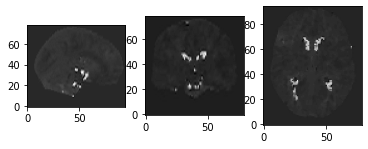

<module 'matplotlib.pyplot' from 'd:\\python\\anaconda3\\envs\\pctnet\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [13]:
display_4D(raw_images)

Image center:  39 47 39
Image center value:  8.529999809339643


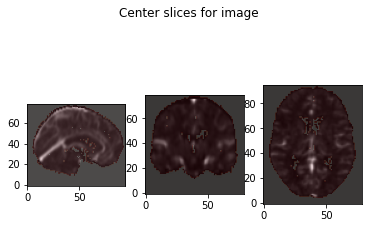

<module 'matplotlib.pyplot' from 'd:\\python\\anaconda3\\envs\\pctnet\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [20]:
display(raw_images[..., 3], raw_mask)

In [22]:
# images, labels = torch.from_numpy(np.expand_dims(raw_images, axis=-1)), \
#                  torch.from_numpy(np.expand_dims(raw_labels, axis=-1))
images, labels = torch.from_numpy(raw_images), \
                 torch.from_numpy(np.expand_dims(raw_labels, axis=-1))


seed = 7533
max_output_channels = 2
print(images.shape)
labels.shape

torch.Size([79, 95, 79, 4])


torch.Size([79, 95, 79, 1])

In [25]:
flip_axis = (2)
random_flip_prob = 1
flip = RandomFlipTransform(axes=flip_axis, flip_probability=1, p=random_flip_prob, seed=seed, max_output_channels=max_output_channels)

flipped_image, flipped_label = flip(images, labels)

print(flipped_image.numpy().shape)
print(flipped_label.numpy().shape)
#display(flipped_image.numpy(), mask=flipped_label.numpy())

RuntimeError: The input tensor must have 4 dimensions (channels, i, j, k), but has 5: torch.Size([1, 79, 95, 79, 4])

In [ ]:
elastic = RandomElasticTransform(max_displacement=[15, 15, 5],
                                   num_control_points=(7, 7, 7),
                                   image_interpolation='bspline',
                                   seed=seed, p=1,
                                   max_output_channels=max_output_channels, verbose=True)

elastic_image, elastic_label = elastic(images, labels)

plt.imshow(elastic_image.numpy()[..., 45, 0], cmap='gray')
plt.imshow(elastic_label.numpy()[..., 45, 0], cmap='Blues', alpha=0.4)

display(elastic_image.numpy(), mask=elastic_label.numpy())

In [ ]:
shift_val = (5, 5)  # translation range
rotate_val = (5, 5)  # rotation range
scale_val = (1.1, 1.1) # scaling range

affine = RandomAffineTransform(scales=scale_val, degrees=rotate_val, translation=shift_val,
                                  isotropic=True, default_pad_value=0,
                                  image_interpolation='bspline', seed=seed, p=1,
                                  max_output_channels=max_output_channels, verbose=True)

affine_image, affine_label = affine(images, labels)

display(affine_image.numpy(), mask=affine_label.numpy())
plt.imshow(affine_image.numpy()[..., 35, 0], cmap='gray')
plt.imshow(affine_label.numpy()[..., 35, 0], cmap='Blues', alpha=0.4)

In [ ]:
noise_mean = np.mean(raw_images[raw_mask]) # find appropriate mean by taking mean of masked image
print('Mean of input image:', noise_mean)
noise_std = (0.75, 0.75)  # range of noise std

noise = RandomNoiseTransform(mean=noise_mean, std=noise_std, seed=seed, p=1,
                                 max_output_channels=max_output_channels)

noise_image, noise_label = noise(images, labels)

display(noise_image.numpy(), mask=noise_label.numpy())
plt.imshow(noise_image.numpy()[..., 35, 0], cmap='gray')